##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to load and preprocess an image dataset in two ways. First, you will use high-level Keras preprocessing [utilities](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) and [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing). Next, you will write your own input pipeline from scratch using [tf.data](https://www.tensorflow.org/guide/data).

## Setup

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [3]:
print(tf.__version__)

2.3.0


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains 5 sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

After downloading (218MB), you should now have a copy of the flower photos available. There are 3670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

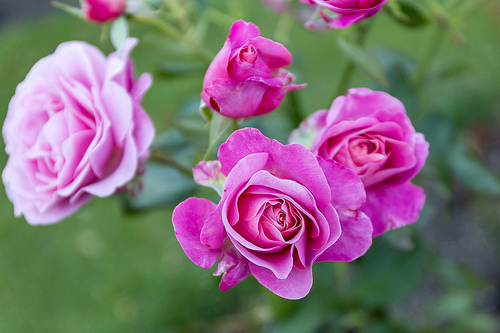

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

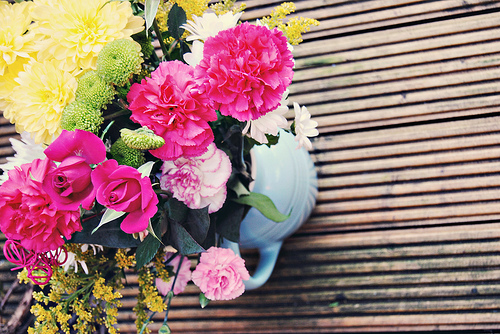

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load using keras.preprocessing

Let's load these images off disk using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

Note: The Keras Preprocesing utilities and layers introduced in this section are currently experimental and may change.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first 9 images from the training dataset.

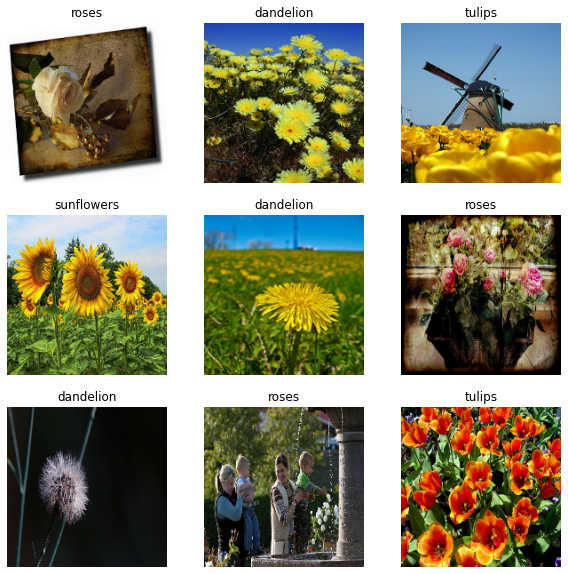

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 


Note: you can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [14]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96902645


Or, you can include the layer inside your model definition to simplify deployment. We will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `Rescaling(1./127.5, offset=-1)`

Note: we previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer instead.


### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, we will show how to train a simple model using the datasets we just prepared. This model has not been tuned in any way - the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit this [tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [17]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: we will only train for a few epochs so this tutorial runs quickly. 

In [19]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 0s - loss: 1.5932 - accuracy: 0.2812

 3/92 [..............................] - ETA: 2s - loss: 1.7486 - accuracy: 0.2812

 4/92 [>.............................] - ETA: 2s - loss: 1.6969 - accuracy: 0.2812

 5/92 [>.............................] - ETA: 3s - loss: 1.6890 - accuracy: 0.2625

 6/92 [>.............................] - ETA: 3s - loss: 1.6933 - accuracy: 0.2865

 7/92 [=>............................] - ETA: 3s - loss: 1.6762 - accuracy: 0.2857

 8/92 [=>............................] - ETA: 3s - loss: 1.6651 - accuracy: 0.2891

 9/92 [=>............................] - ETA: 3s - loss: 1.6535 - accuracy: 0.2986

10/92 [==>...........................] - ETA: 3s - loss: 1.6476 - accuracy: 0.2937

11/92 [==>...........................] - ETA: 3s - loss: 1.6400 - accuracy: 0.3011

12/92 [==>...........................] - ETA: 3s - loss: 1.6330 - accuracy: 0.2969

13/92 [===>..........................] - ETA: 3s - loss: 1.6305 - accuracy: 0.2909

14/92 [===>..........................] - ETA: 3s - loss: 1.6225 - accuracy: 0.2946

15/92 [===>..........................] - ETA: 3s - loss: 1.6178 - accuracy: 0.2958

16/92 [====>.........................] - ETA: 3s - loss: 1.6136 - accuracy: 0.2969

17/92 [====>.........................] - ETA: 3s - loss: 1.6112 - accuracy: 0.2941

18/92 [====>.........................] - ETA: 3s - loss: 1.6047 - accuracy: 0.2986

19/92 [=====>........................] - ETA: 3s - loss: 1.6000 - accuracy: 0.2977

20/92 [=====>........................] - ETA: 3s - loss: 1.5960 - accuracy: 0.2953

21/92 [=====>........................] - ETA: 3s - loss: 1.5896 - accuracy: 0.2946

22/92 [======>.......................] - ETA: 3s - loss: 1.5800 - accuracy: 0.2969

23/92 [======>.......................] - ETA: 3s - loss: 1.5708 - accuracy: 0.3043

24/92 [======>.......................] - ETA: 3s - loss: 1.5678 - accuracy: 0.3086

25/92 [=======>......................] - ETA: 3s - loss: 1.5652 - accuracy: 0.3075

26/92 [=======>......................] - ETA: 3s - loss: 1.5590 - accuracy: 0.3125

27/92 [=======>......................] - ETA: 3s - loss: 1.5528 - accuracy: 0.3148

28/92 [========>.....................] - ETA: 3s - loss: 1.5462 - accuracy: 0.3203

29/92 [========>.....................] - ETA: 3s - loss: 1.5434 - accuracy: 0.3211

30/92 [========>.....................] - ETA: 3s - loss: 1.5367 - accuracy: 0.3240

31/92 [=========>....................] - ETA: 3s - loss: 1.5264 - accuracy: 0.3306

32/92 [=========>....................] - ETA: 3s - loss: 1.5179 - accuracy: 0.3330

34/92 [==========>...................] - ETA: 3s - loss: 1.5064 - accuracy: 0.3392

36/92 [==========>...................] - ETA: 3s - loss: 1.4887 - accuracy: 0.3438

37/92 [===========>..................] - ETA: 2s - loss: 1.4836 - accuracy: 0.3454

38/92 [===========>..................] - ETA: 2s - loss: 1.4763 - accuracy: 0.3495

39/92 [===========>..................] - ETA: 2s - loss: 1.4717 - accuracy: 0.3526

40/92 [============>.................] - ETA: 2s - loss: 1.4619 - accuracy: 0.3578

41/92 [============>.................] - ETA: 2s - loss: 1.4523 - accuracy: 0.3613

42/92 [============>.................] - ETA: 2s - loss: 1.4493 - accuracy: 0.3638

43/92 [=============>................] - ETA: 2s - loss: 1.4452 - accuracy: 0.3656

44/92 [=============>................] - ETA: 2s - loss: 1.4395 - accuracy: 0.3658

45/92 [=============>................] - ETA: 2s - loss: 1.4353 - accuracy: 0.3694

46/92 [==============>...............] - ETA: 2s - loss: 1.4316 - accuracy: 0.3696

47/92 [==============>...............] - ETA: 2s - loss: 1.4292 - accuracy: 0.3710

48/92 [==============>...............] - ETA: 2s - loss: 1.4294 - accuracy: 0.3730

49/92 [==============>...............] - ETA: 2s - loss: 1.4249 - accuracy: 0.3724

50/92 [===============>..............] - ETA: 2s - loss: 1.4209 - accuracy: 0.3738

51/92 [===============>..............] - ETA: 2s - loss: 1.4208 - accuracy: 0.3750

52/92 [===============>..............] - ETA: 2s - loss: 1.4216 - accuracy: 0.3768

53/92 [================>.............] - ETA: 2s - loss: 1.4212 - accuracy: 0.3785

54/92 [================>.............] - ETA: 2s - loss: 1.4175 - accuracy: 0.3796

55/92 [================>.............] - ETA: 1s - loss: 1.4138 - accuracy: 0.3807

56/92 [=================>............] - ETA: 1s - loss: 1.4128 - accuracy: 0.3795

57/92 [=================>............] - ETA: 1s - loss: 1.4098 - accuracy: 0.3799

58/92 [=================>............] - ETA: 1s - loss: 1.4087 - accuracy: 0.3809

59/92 [==================>...........] - ETA: 1s - loss: 1.4069 - accuracy: 0.3819

60/92 [==================>...........] - ETA: 1s - loss: 1.4025 - accuracy: 0.3844

61/92 [==================>...........] - ETA: 1s - loss: 1.3993 - accuracy: 0.3852

62/92 [===================>..........] - ETA: 1s - loss: 1.3969 - accuracy: 0.3876

63/92 [===================>..........] - ETA: 1s - loss: 1.3925 - accuracy: 0.3894

64/92 [===================>..........] - ETA: 1s - loss: 1.3868 - accuracy: 0.3936

65/92 [====================>.........] - ETA: 1s - loss: 1.3830 - accuracy: 0.3952

66/92 [====================>.........] - ETA: 1s - loss: 1.3812 - accuracy: 0.3954

68/92 [=====================>........] - ETA: 1s - loss: 1.3710 - accuracy: 0.3994

69/92 [=====================>........] - ETA: 1s - loss: 1.3708 - accuracy: 0.3995

70/92 [=====================>........] - ETA: 1s - loss: 1.3678 - accuracy: 0.4009

71/92 [======================>.......] - ETA: 1s - loss: 1.3606 - accuracy: 0.4040

72/92 [======================>.......] - ETA: 1s - loss: 1.3540 - accuracy: 0.4071

73/92 [======================>.......] - ETA: 1s - loss: 1.3502 - accuracy: 0.4092

74/92 [=======================>......] - ETA: 0s - loss: 1.3449 - accuracy: 0.4109

75/92 [=======================>......] - ETA: 0s - loss: 1.3446 - accuracy: 0.4121

76/92 [=======================>......] - ETA: 0s - loss: 1.3472 - accuracy: 0.4116

77/92 [========================>.....] - ETA: 0s - loss: 1.3424 - accuracy: 0.4140

78/92 [========================>.....] - ETA: 0s - loss: 1.3388 - accuracy: 0.4159

79/92 [========================>.....] - ETA: 0s - loss: 1.3401 - accuracy: 0.4146

81/92 [=========================>....] - ETA: 0s - loss: 1.3363 - accuracy: 0.4182

82/92 [=========================>....] - ETA: 0s - loss: 1.3370 - accuracy: 0.4188

83/92 [==========================>...] - ETA: 0s - loss: 1.3347 - accuracy: 0.4187

84/92 [==========================>...] - ETA: 0s - loss: 1.3330 - accuracy: 0.4189

90/92 [============================>.] - ETA: 0s - loss: 1.3258 - accuracy: 0.4257

92/92 [==============================] - ETA: 0s - loss: 1.3282 - accuracy: 0.4240

92/92 [==============================] - 6s 66ms/step - loss: 1.3282 - accuracy: 0.4240 - val_loss: 1.1035 - val_accuracy: 0.5804


Epoch 2/3
 1/92 [..............................] - ETA: 0s - loss: 1.2099 - accuracy: 0.5625

 7/92 [=>............................] - ETA: 0s - loss: 1.0992 - accuracy: 0.5446

13/92 [===>..........................] - ETA: 0s - loss: 1.0707 - accuracy: 0.5433

19/92 [=====>........................] - ETA: 0s - loss: 1.0551 - accuracy: 0.5543

25/92 [=======>......................] - ETA: 0s - loss: 1.0556 - accuracy: 0.5663

31/92 [=========>....................] - ETA: 0s - loss: 1.0554 - accuracy: 0.5716

37/92 [===========>..................] - ETA: 0s - loss: 1.0319 - accuracy: 0.5777

43/92 [=============>................] - ETA: 0s - loss: 1.0268 - accuracy: 0.5836

49/92 [==============>...............] - ETA: 0s - loss: 1.0433 - accuracy: 0.5746

55/92 [================>.............] - ETA: 0s - loss: 1.0449 - accuracy: 0.5767

61/92 [==================>...........] - ETA: 0s - loss: 1.0479 - accuracy: 0.5784

67/92 [====================>.........] - ETA: 0s - loss: 1.0365 - accuracy: 0.5868

73/92 [======================>.......] - ETA: 0s - loss: 1.0280 - accuracy: 0.5903

79/92 [========================>.....] - ETA: 0s - loss: 1.0258 - accuracy: 0.5926

85/92 [==========================>...] - ETA: 0s - loss: 1.0245 - accuracy: 0.5919

91/92 [============================>.] - ETA: 0s - loss: 1.0302 - accuracy: 0.5920

92/92 [==============================] - 1s 11ms/step - loss: 1.0304 - accuracy: 0.5913 - val_loss: 0.9515 - val_accuracy: 0.6267


Epoch 3/3
 1/92 [..............................] - ETA: 0s - loss: 0.9947 - accuracy: 0.6250

 7/92 [=>............................] - ETA: 0s - loss: 0.8956 - accuracy: 0.6830

13/92 [===>..........................] - ETA: 0s - loss: 0.8998 - accuracy: 0.6635

19/92 [=====>........................] - ETA: 0s - loss: 0.8982 - accuracy: 0.6612

25/92 [=======>......................] - ETA: 0s - loss: 0.8892 - accuracy: 0.6725

31/92 [=========>....................] - ETA: 0s - loss: 0.8863 - accuracy: 0.6734

37/92 [===========>..................] - ETA: 0s - loss: 0.8759 - accuracy: 0.6698

43/92 [=============>................] - ETA: 0s - loss: 0.8727 - accuracy: 0.6722

49/92 [==============>...............] - ETA: 0s - loss: 0.8854 - accuracy: 0.6633

55/92 [================>.............] - ETA: 0s - loss: 0.8835 - accuracy: 0.6648

61/92 [==================>...........] - ETA: 0s - loss: 0.8865 - accuracy: 0.6639

67/92 [====================>.........] - ETA: 0s - loss: 0.8773 - accuracy: 0.6688

73/92 [======================>.......] - ETA: 0s - loss: 0.8724 - accuracy: 0.6708

79/92 [========================>.....] - ETA: 0s - loss: 0.8698 - accuracy: 0.6705

85/92 [==========================>...] - ETA: 0s - loss: 0.8659 - accuracy: 0.6739

91/92 [============================>.] - ETA: 0s - loss: 0.8727 - accuracy: 0.6690

92/92 [==============================] - 1s 11ms/step - loss: 0.8712 - accuracy: 0.6689 - val_loss: 0.9268 - val_accuracy: 0.6471


Note: you can also write a custom training loop instead of using `model.fit`. To learn more, visit this [tutorial](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).

You may notice the validation accuracy is low to the compared to the training accuracy, indicating our model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control

The above keras.preprocessing utilities are a convenient way to create a `tf.data.Dataset` from a directory of images. For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the zip we downloaded earlier.

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/roses/1445228333_59a07e0801.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/14128835667_b6a916222c.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/roses/7551637034_55ae047756_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/4574736702_b15ecf97d0_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/roses/6867597533_d65d1c39fb_n.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into train and validation:

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

You can see the length of each dataset as follows:

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [25]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, see the [Input Pipeline Performance](../../guide/performance/datasets) guide.

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously.

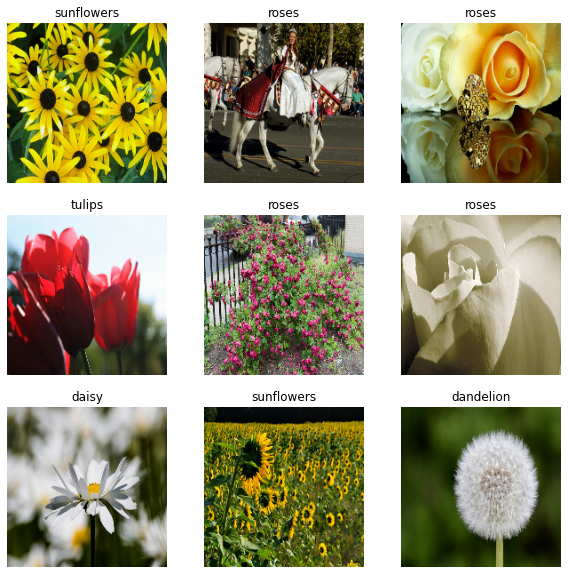

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by the `keras.preprocessing` above. You can continue training the model with it. As before, we will train for just a few epochs to keep the running time short.

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 0s - loss: 0.6722 - accuracy: 0.6562

 4/92 [>.............................] - ETA: 1s - loss: 0.8374 - accuracy: 0.6641

 8/92 [=>............................] - ETA: 1s - loss: 0.8272 - accuracy: 0.6797

12/92 [==>...........................] - ETA: 1s - loss: 0.8029 - accuracy: 0.6901

16/92 [====>.........................] - ETA: 1s - loss: 0.7958 - accuracy: 0.6914

20/92 [=====>........................] - ETA: 1s - loss: 0.7812 - accuracy: 0.6984

24/92 [======>.......................] - ETA: 0s - loss: 0.7489 - accuracy: 0.7083

28/92 [========>.....................] - ETA: 0s - loss: 0.7488 - accuracy: 0.7076

32/92 [=========>....................] - ETA: 0s - loss: 0.7509 - accuracy: 0.7090

36/92 [==========>...................] - ETA: 0s - loss: 0.7489 - accuracy: 0.7101

40/92 [============>.................] - ETA: 0s - loss: 0.7450 - accuracy: 0.7109

44/92 [=============>................] - ETA: 0s - loss: 0.7378 - accuracy: 0.7145

48/92 [==============>...............] - ETA: 0s - loss: 0.7359 - accuracy: 0.7188

52/92 [===============>..............] - ETA: 0s - loss: 0.7346 - accuracy: 0.7206

56/92 [=================>............] - ETA: 0s - loss: 0.7336 - accuracy: 0.7210

59/92 [==================>...........] - ETA: 0s - loss: 0.7418 - accuracy: 0.7193

64/92 [===================>..........] - ETA: 0s - loss: 0.7422 - accuracy: 0.7197

70/92 [=====================>........] - ETA: 0s - loss: 0.7379 - accuracy: 0.7214

76/92 [=======================>......] - ETA: 0s - loss: 0.7369 - accuracy: 0.7220

82/92 [=========================>....] - ETA: 0s - loss: 0.7294 - accuracy: 0.7264

88/92 [===========================>..] - ETA: 0s - loss: 0.7319 - accuracy: 0.7259

92/92 [==============================] - 2s 19ms/step - loss: 0.7267 - accuracy: 0.7272 - val_loss: 0.7963 - val_accuracy: 0.7098


Epoch 2/3
 1/92 [..............................] - ETA: 0s - loss: 0.5556 - accuracy: 0.8750

 7/92 [=>............................] - ETA: 0s - loss: 0.5310 - accuracy: 0.8304

13/92 [===>..........................] - ETA: 0s - loss: 0.5216 - accuracy: 0.8197

19/92 [=====>........................] - ETA: 0s - loss: 0.5385 - accuracy: 0.8043

25/92 [=======>......................] - ETA: 0s - loss: 0.5352 - accuracy: 0.8037

31/92 [=========>....................] - ETA: 0s - loss: 0.5208 - accuracy: 0.8075

37/92 [===========>..................] - ETA: 0s - loss: 0.5191 - accuracy: 0.8066

43/92 [=============>................] - ETA: 0s - loss: 0.5238 - accuracy: 0.8074

49/92 [==============>...............] - ETA: 0s - loss: 0.5267 - accuracy: 0.8036

55/92 [================>.............] - ETA: 0s - loss: 0.5346 - accuracy: 0.7960

61/92 [==================>...........] - ETA: 0s - loss: 0.5242 - accuracy: 0.8007

67/92 [====================>.........] - ETA: 0s - loss: 0.5326 - accuracy: 0.7971

73/92 [======================>.......] - ETA: 0s - loss: 0.5406 - accuracy: 0.7958

79/92 [========================>.....] - ETA: 0s - loss: 0.5379 - accuracy: 0.7991

85/92 [==========================>...] - ETA: 0s - loss: 0.5391 - accuracy: 0.7974

91/92 [============================>.] - ETA: 0s - loss: 0.5397 - accuracy: 0.7981

92/92 [==============================] - 1s 11ms/step - loss: 0.5384 - accuracy: 0.7987 - val_loss: 0.8067 - val_accuracy: 0.6894


Epoch 3/3
 1/92 [..............................] - ETA: 0s - loss: 0.2902 - accuracy: 0.9375

 7/92 [=>............................] - ETA: 0s - loss: 0.3832 - accuracy: 0.8571

13/92 [===>..........................] - ETA: 0s - loss: 0.3570 - accuracy: 0.8678

18/92 [====>.........................] - ETA: 0s - loss: 0.3389 - accuracy: 0.8767

24/92 [======>.......................] - ETA: 0s - loss: 0.3153 - accuracy: 0.8867

30/92 [========>.....................] - ETA: 0s - loss: 0.3304 - accuracy: 0.8792

35/92 [==========>...................] - ETA: 0s - loss: 0.3145 - accuracy: 0.8875

41/92 [============>.................] - ETA: 0s - loss: 0.3191 - accuracy: 0.8857

47/92 [==============>...............] - ETA: 0s - loss: 0.3253 - accuracy: 0.8836

53/92 [================>.............] - ETA: 0s - loss: 0.3275 - accuracy: 0.8838

59/92 [==================>...........] - ETA: 0s - loss: 0.3300 - accuracy: 0.8814

65/92 [====================>.........] - ETA: 0s - loss: 0.3397 - accuracy: 0.8764

71/92 [======================>.......] - ETA: 0s - loss: 0.3484 - accuracy: 0.8719

77/92 [========================>.....] - ETA: 0s - loss: 0.3474 - accuracy: 0.8726

83/92 [==========================>...] - ETA: 0s - loss: 0.3443 - accuracy: 0.8742

89/92 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8761

92/92 [==============================] - 1s 11ms/step - loss: 0.3382 - accuracy: 0.8770 - val_loss: 1.0317 - val_accuracy: 0.6662


## Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using tf.data. As a next step, you can learn how to add data augmentation by visiting this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation). To learn more about tf.data, you can visit this [guide](https://www.tensorflow.org/guide/data).